# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

3 PROBLEMES
* ESS toujours au max à chaque itération --> sigma2 = 10e141 écrase (consumption - x_pred)
* valeurs négatives de x
* x_season est négligeable devant x_heat


In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage

### Parameters

In [48]:
M=10**4 #number of particles
n_pred=48  #number of predictions
N_daytype=8  #number of day types

In [75]:
#Define functions for filtering and regularization of weigths for Particle Fitler algo 3.10

def ESS(w,n):
    return(1/(sum(w[n,:])**2))

def resid_resample(x_h,w_h):  #algorithm 3.5 - Residual Multinomial Sampling
    #R=sum(np.floor(M*w_h))  #number of (normalized) weights over 1/M
    R=len(w_h[w_h>1/M])
    print("R=",R)
    z=np.zeros(M)
    #z[:R-1]=x_h[:R-1]
    z[:R]=x_h[w_h>1/M]  #Copy the R particles having weight >1/M
    w_=np.ones(M)
    for j in range(M):
        w_[j]=(M*w_h[j]-np.floor(M*w_h[j]))/(M-R)
    print("w_:",w_)
    z[R:]=np.random.multinomial(1,w_[R:],1)*w_[R:]
    w=np.ones(M)*(1/M)
    return z, w

def regul(x,w):  #algorithm 3.6
    eps=sp.ndimage.filters.gaussian_filter(x,sigma=1)  #assume gaussian kernel
    h=0.2 #bandwidth
    z=x+h*(np.cov(x)**0.5)*eps
    return(z)

In [5]:
#test the functions on random sample
M=10
x_temp=abs(npr.normal(size=10))
w_temp=np.repeat(0.1,10)*npr.uniform(0.1,1.5,size=10)
#print(w_temp)
xtest,wtest=resid_resample(x_temp,w_temp)
print(xtest)
print(wtest)
M=10**5

R= 7.0
w_: [ 0.0159879   0.06046857  0.21358683  0.06269248  0.06383073  0.14574677
  0.27535135  0.13235386  0.01118209  0.00861518]
[ 2.25074427  1.61645655  1.15057606  1.27556356  1.93147651  1.70185933
  0.30205804  0.13235386  0.          0.        ]
[ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1]


/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [6]:
regul(npr.normal(size=10),np.repeat(0.1,10))

array([ 1.67835952, -0.49256673,  0.18780915, -1.67773688, -0.1797055 ,
        1.42578154, -0.28216233,  0.36459449, -1.99712357,  1.00452261])

### Load temperatures data

In [4]:
df_temp=pd.read_csv('data/temp_2016.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,t,hour
1707,2016-01-01,9.044444,09:00
1710,2016-01-01,11.005556,18:00
1709,2016-01-01,11.437736,15:00
1708,2016-01-01,11.196296,12:00
1711,2016-01-01,10.683333,21:00


In [5]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [619]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
149461,2016-01-02 08:00:00,2016-01-02,09:00,52975,DÃ©finitive,8
149460,2016-01-02 06:00:00,2016-01-02,07:00,49417,DÃ©finitive,8
149462,2016-01-02 09:00:00,2016-01-02,10:00,55737,DÃ©finitive,8
149463,2016-01-02 10:00:00,2016-01-02,11:00,57237,DÃ©finitive,8
149464,2016-01-02 12:00:00,2016-01-02,13:00,61223,DÃ©finitive,8


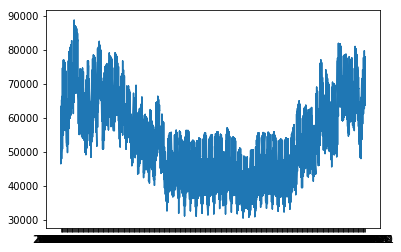

In [575]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

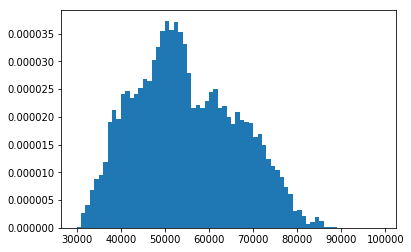

In [228]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

### Set variables of electricity demand for partile 

In [597]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])
temperature_ts = T_h[:30] #france mean temp in jan 2016
daytype_ts = list(df[df['Heure']=='15:00']['daytype'][:30])

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option A: Set values by hand

In [220]:
#Add a bit of noise with uniform random
#s=8000*np.ones(M)*npr.uniform(0.5,1.5,size=M)
#sigma2_g_star=(10**5)*npr.uniform(0.5,1.5,size=M)
#sigma2_s_star=(10**5)*npr.uniform(0.5,1.5,size=M)
sigma_g_init=1.27*10**(8/2)
sigma_s_init=(2*7.9)*10**3
u_h=14 #mean of N(14,1)
kappa=np.array([1/9]*9)
sigma2=2.7*10**7
g_heat_init = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s_init = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)
sigma_s_star_2_evol=7.9*10**7
sigma_g_star_2_evol=1.27*10**8

x_init=x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0]+x_heat(g_heat_init,15,sigma_g_init)[0]
w_init= np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


In [221]:
x_init[:10]

array([ 11207.26366299, -12211.21377574,  41578.28481568,  21288.25209163,
        17534.93102177,  18438.30767951,   -255.3084417 ,  16757.83731906,
         2232.63649792,   -585.02155657])

In [222]:
print(x_season(df.daytype[15],kappa,s_init,sigma_s_init)[0][:10])

[ 1843.41800756   786.89542877  2274.19344192  1688.18031182  1343.96757308
  2189.02820228  1764.32360492  1236.34429908  1779.03294738  1651.16947868]


In [223]:
print(x_heat(g_heat_init,15,sigma_g_init)[0][:10])

[  92127.66621109   69765.71135115  122067.91192941  102363.89233547
   98954.78400435   99013.10003289   80744.18850903   98285.31357563
   83217.4241062    80527.62952041]


In [61]:
g_heat_init

array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04, ...,
        -1.29732429e+04,  -1.61914297e+04,  -1.74323565e+04])

In [224]:
#Compute w_init
w_init = np.exp(-(np.square(consumption[15]-x_init))/(2*sigma2))
#print(w_init[:100])
sum(w_init)/M
sum(np.floor(w_init*M))
w_norm=w_init/np.sum(w_init)
print(sum(np.floor(M*w_norm)))
print(len(w_norm[w_norm>1/M]))

95753.0
6844


In [225]:
np.mean(w_init)

0.032082923777483889

In [226]:
M*w_norm[:100]

array([  1.52552272e-22,   3.11302950e-47,   1.16201261e-03,
         1.24695734e-14,   2.19243835e-17,   1.05854323e-16,
         1.58689986e-33,   5.52369073e-18,   5.80698854e-31,
         7.13452331e-34,   9.27122476e-22,   2.27721400e-19,
         2.38308323e-49,   1.50119488e-37,   3.40189102e-23,
         9.01061677e-22,   1.76084160e+00,   6.10382893e-51,
         3.64980911e-63,   3.88502441e-21,   2.15502111e-62,
         1.72578457e-06,   2.89343761e+01,   3.56221365e-69,
         5.47743855e-03,   4.94628913e-61,   1.20054452e-20,
         1.69905702e+00,   1.63732242e-32,   4.40127160e-72,
         1.61238049e-47,   7.19830368e-48,   1.00672345e-05,
         4.12948250e-18,   3.08818887e-19,   2.05399393e-64,
         7.38463785e-56,   5.34740482e-32,   3.83103647e-15,
         1.42696576e-55,   2.65233930e-17,   8.71408852e-64,
         9.88550413e-62,   2.64554394e-34,   2.11877342e-27,
         4.41729559e-52,   2.17271985e-50,   3.74762243e-69,
         5.60958100e-07,

In [156]:
consumption[15]

65044

### Option B: generate initial parameters based on prior distribution

In [ ]:
sigma2=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g_star=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_s=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
sigma2_g=invgamma.rvs(a=0.01,scale=0.01,size=M)**0.5
g_h = stats.truncnorm.rvs(-np.inf,0,loc=0,scale=10**4,size=M)
s = stats.truncnorm.rvs(np.inf,0,loc=0,scale=10**4,size=M)


u_h=npr.normal(14,1)  #fixed parameter, invariant to time
k_day=npr.dirichlet(np.ones(N_daytype),1)[0]

C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)
C:\Users\Zakarya\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2631: RuntimeWarning: overflow encountered in true_divide
  return 1.0 / sc.gammainccinv(a, q)


#### 1.B. Calculate x and w at initial state based on initial parameters

In [ ]:
#initialize matrix of x, x_heat, x_season
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])
x =np.zeros([n_pred+1,M])

daytype_init=1
day_init=1

#Calculate x0 and w0 before filtering
x_season[0,:]=k_day[daytype_init]*s
if T_h[day_init]-u_h >0:
    x_heat[0,:]=g_h*(T_h[day_init]-u_h)*1
else:
    x_heat[0,:]=np.zeros(M)

x_0=x_season[0,:]+x_heat[0,:]   #ignore x_cool for now
w0_=x_0+npr.normal(0,sigma2,size=M)  #compute w_wave = g(y_0 l X_0)

#### 2.B.Compute the weights and re-assess the values of X_0 and w_0 based on ESS value


In [186]:
import math
w =np.zeros([n_pred+1,M])  #initalize matrix of weights w
w0_h=w0_/sum(w0_)   #set w_hat
ESS_0=1/(sum(w0_h)**2)  #calculate ESS
if math.isnan(ESS_0):
    ESS_0=1
print(ESS_0)
if ESS_0 <0.001*M:
    x[0,:]=x_0
    w[0,:]=np.ones(M)*(1/M)  #reset the weights
if (ESS_0>=0.001*M and ESS_0<0.5*M):
    x_temp=resid_resample(x_0,w0_h)
    w_temp=np.ones(M)*(1/M)
    x[0,:]=regul(x_temp,w_temp)
    w[0,:]=w_temp
if ESS_0>=0.5*M:
    x[0,:]=x_0
    w[0,:]=w0_

### Option C: MCMC using MHA or Gibbs (TBA)

In [286]:
import numpy as np
from scipy.stats import truncnorm, invgamma
import math

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [620]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
#kappa = k_day[0].tolist()

In [621]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180110-102854.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init["x_init"][:20]

array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04,
         6.81207363e+04,   7.14502802e+04,   5.07239317e+04,
         6.87925901e+04,   6.79254776e+04,   6.64789388e+04,
         6.69291468e+04,   7.02870564e+04,   6.72162235e+04,
         6.13931229e+04,   6.70012333e+04,   6.97843307e+04,
         6.89930685e+04,   6.82153628e+04,   6.36456017e+04,
         7.50874631e+04,   7.18940313e+04])

In [622]:
parameters_init

{'g_heat_init': array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04, ...,
         -1.29732429e+04,  -1.61914297e+04,  -1.74323565e+04]),
 'kappa': array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111]),
 's_init': array([  1.33102713e+64,   6.72597280e+05,   1.58876634e+05, ...,
          3.91430788e-08,   3.82795043e-08,   9.78069125e-08]),
 'sigma2': 27000000,
 'sigma_g_init': 1.7189511907681099e+27,
 'sigma_s_init': 6.3306065683604752e-08,
 'u_h': 13,
 'w_init': array([ 0.        ,  0.25286083,  0.94446275, ...,  0.01100679,
         0.88847701,  0.8894034 ]),
 'x_init': array([  1.47891903e+63,   7.69395809e+04,   6.65664387e+04, ...,
          5.27185416e+04,   6.57960826e+04,   7.08387576e+04])}

In [623]:
len(x_init)

10000

In [624]:
parameters_init["s_init"][:20]

array([  1.33102713e+64,   6.72597280e+05,   1.58876634e+05,
         1.18739246e+05,   9.82904490e+04,   8.54230162e+04,
         7.64067350e+04,   6.96581133e+04,   6.43746420e+04,
         6.01005169e+04,   5.65553245e+04,   5.35560219e+04,
         5.09775258e+04,   4.87311797e+04,   4.67522382e+04,
         4.49922190e+04,   4.34140299e+04,   4.19887541e+04,
         4.06934668e+04,   3.95097165e+04])

In [625]:
parameters_init["g_heat_init"][:20]

array([ -9.99946914e+27,  -5.42998824e+02,  -1.20368741e+04,
        -1.35168312e+04,  -1.48953090e+04,  -1.01466967e+04,
        -1.48396528e+04,  -1.48107955e+04,  -1.45992888e+04,
        -1.48269447e+04,  -1.57502113e+04,  -1.50765346e+04,
        -1.37140601e+04,  -1.51555534e+04,  -1.58945417e+04,
        -1.57479477e+04,  -1.55997181e+04,  -1.45141394e+04,
        -1.73652267e+04,  -1.66117380e+04])

In [626]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
#s_evol=parameters_init['s_evol']
#g_heat_evol=parameters_init['g_heat_evol']
#sigma_s_star_2_evol=parameters_init['sigma_s_star_2_evol']
#sigma_g_star_2_evol=parameters_init['sigma_g_star_2_evol']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [627]:
sigma_g_init=1.27*10**(8/2)
sigma_s_init=(2*7.9)*10**3

In [628]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

In [629]:
x_init[:10]

array([ 68269.02114799,  76939.58088649,  66566.43869336,  68120.73625038,
        71450.28024352,  50723.93174556,  68792.59009254,  67925.47762795,
        66478.93882123,  66929.14684406])

### Part 2: regularize weights and x if necessary

In [297]:
"""
Set of Parameters:
w_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,
x_init, s_evol,g_heat_evol,
sigma_s_star_2_evol, sigma_g_star_2_evol
"""

'\nSet of Parameters:\nw_init, s_init, g_heat_init, sigma_s_init, sigma_g_init,\nx_init, s_evol,g_heat_evol,\nsigma_s_star_2_evol, sigma_g_star_2_evol\n'

In [630]:
#STEP 2 OF PARTICLE FILTER
def resample(x_pred,w_prev,n):   
    #compute y_n
    y_n=np.exp(-np.square(consumption_day_ahead[n-1]-x_pred)/(2*sigma2))
    #compute new weights
    if n>0:
        w_=w_prev*y_n
    else:
        w_=w_prev
    #likelihood of y_n
    lh_y_n=np.sum(np.log(y_n))
    #normalize weights
    w_h=w_/sum(w_)
    #calculate ESS
    ESS=1/sum(np.square(w_h))
    x =np.zeros(M)
    w =np.zeros(M)
    print("ESS of normalized weights=",round(ESS,6))
    if ESS <0.001*M: #reset the weights, keep x predicted as such
        print("ESS <0.001*M")
        x=x_pred
        if n==0:
            w=np.ones(M)*(1/M)
        w=w_prev
    if (ESS>=0.001*M and ESS<0.5*M):  #reset all the weights, add some noise to a fraction of the x's
        print("ESS>=0.001*M and ESS_0<0.5*M")
        x_temp,w_temp=resid_resample(x_pred,w_h)
        x=regul(x_temp,w_temp)
        w=w_temp
    if ESS>=0.5*M:  #No degeneracy
        print("ESS>=0.5*M")
        x=x_pred
        w=w_h
    print("new ESS=",round(1/sum(np.square(w)),6))
    return x,w,ESS,lh_y_n

In [631]:
#initialize matrix of x_heat, x_season
ESS=np.array(np.ones(n_pred+1))
x =np.zeros([n_pred+1,M])
w =np.zeros([n_pred+1,M])
lh_y =np.zeros(n_pred+1)
x_season =np.zeros([n_pred+1,M]) 
x_heat =np.zeros([n_pred+1,M])

x[0,:],w[0,:],ESS[0],lh_y=resample(x_init,w_init,0)
#w[0,:]=resample(x_init,w_init,0)[1]

ESS of normalized weights= 8651.09274
ESS>=0.5*M
new ESS= 8651.09274


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [632]:
def x_season(day_type,k_day,s_prev,sigma_s_prev):
    nu=truncnorm.rvs(a = (-sigma_s_prev-0) / sigma_g_init , b = np.inf, loc= 0, scale = sigma_s_init, size=M)[0]
    sigma_s=sigma_s_prev+nu
    err=truncnorm.rvs(a = -s_prev / sigma_s , b = np.inf, loc= 0, scale = sigma_s, size=M)[0]
    s=s_prev+err
    x_s=s*k_day[day_type]
    return x_s, s, sigma_s

def x_heat(g_h_prev,day,sigma_g_prev):
    nu=truncnorm.rvs(a = -sigma_g_prev / sigma_g_init , b = np.inf, loc= 0, scale = sigma_g_init, size=M)[0]
    sigma_g=sigma_g_prev+nu
    err=truncnorm.rvs(a = -np.inf , b =(-g_h_prev-0) / sigma_g, loc= 0, scale = sigma_g, size=M)[0]
    g_h=g_h_prev+err
    if(u_h-T_h[day]<0):
        print("No heating effect")
    x_h=g_h*(T_h[day]-u_h)*max(np.sign(u_h-T_h[day]),0)
    return x_h, g_h, sigma_g

In [645]:
daytype=np.array(df.daytype)

In [648]:
daytype[15]

8

In [649]:
print(x_season(daytype[15],kappa,s_init,sigma_s_init)[0])
#print(s_init*kappa[df.daytype[15]])

[  1004.28473551  75737.31585522  18657.24402494 ...,   1004.28473551
   1004.28473551   1004.28473552]


In [650]:
print(x_heat(g_heat_init,16,sigma_g_init)[0])
#print(np.maximum(0,g_heat_init*(T_h[15]-u_h)))

[ 90916.32249249  16954.01267766  69272.43025697 ...,  73534.64220547
  88183.35184217  93831.86653098]


In [698]:
#Initialize parameters
def particle_filter(len_init,len_filtering,s,g_h,sigma_s,sigma_g,sigma,lh_y):
    #s=s_init
    #g_h=g_heat_init
    #sigma_s=sigma_s_init
    #sigma_g=sigma_g_init
    lh_y_n=np.zeros(len_filtering)
    
    for n in range(1,len_filtering):
        print("n=",n)
        #prediction X[n] one day ahead, hourly forecast
        x_pred=x_season(daytype[len_init+n],kappa,s,sigma_s)[0]+x_heat(g_h,n+len_init,sigma_g)[0]
        #print("number of negative values:",len(x_pred[x_pred<0]))
        #print("x_pred mean=","{:.2e}".format(np.sum(w[n-1,:]*x_pred)),"real consumption=","{:.2e}".format(consumption_day_ahead[n]))
        #print("x_pred min=","{:.2e}".format(np.min(x_pred)),"x_pred max","{:.2e}".format(np.max(x_pred)))
        #deal with outliers if ESS drops below epsilon--> algo 3.3
    
        #take new values of parameters to feed x_season and x_heat in the next step
        #(should we assume constant parameters in the baseline model ?)
        s, sigma_s=x_season(daytype[n+len_init],kappa,s,sigma_s)[1:]
        g_h, sigma_g=x_heat(g_h,n,sigma_g)[1:]
        #regularization
        x[n,:],w[n,:],ESS[n],lh_y_n[n]=resample(x_pred,w[n-1,:],n)
        print("------------------------")
    return lh_y_n

In [699]:
log_lh_init=particle_filter(15,10,s_init,g_heat_init,sigma_s_init,sigma_g_init,sigma2**0.5,lh_y_n)


n= 1
ESS of normalized weights= 2291.717629
ESS>=0.001*M and ESS_0<0.5*M
R= 2480
w_: [  7.56032950e-06   1.30868042e-06   2.30422155e-05 ...,   7.63545310e-05
   6.37887006e-05   7.35256547e-07]
new ESS= 10000.0
------------------------
n= 2
ESS of normalized weights= 2.193418
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 3
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 4
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 5
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 6
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 7
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 8
No heating effect
ESS of normalized weights= nan
new ESS= inf
------------------------
n= 9
No heating effect
ESS of normalized weights= nan
new ESS= inf
------------------------


/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


In [365]:
ESS/M

array([  8.65109274e-01,   1.73872829e-01,   3.65798383e-03,
         1.44518476e-02,   1.83252551e-04,   1.45044353e-04,
         8.87489688e-01,   1.59095515e-04,   1.97847692e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04,   1.00000000e-04,   1.00000000e-04,
         1.00000000e-04]

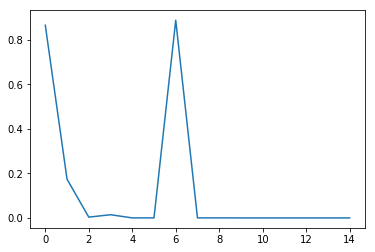

In [366]:
plt.plot(range(15),ESS[:15]/M)
plt.show()

## PMMH

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



#### Initialization of parameters

In [662]:
u_h_current=13
sigma_g_current=10**3
sigma_s_current=10**3
sigma_current=10**3

In [686]:
len_filter_pmmh=10
accept_proba=0
len_iter_mha=10
accept_log_proba=np.zeros(len_filter_pmmh)
accept_rate=0
log_lh_init=np.zeros(len_filter_pmmh)

In [687]:
lh_y_prop=np.zeros([len_filter_pmmh,M])

#### Initialization of hyperparameters

In [688]:
#standard deviation of normal/trunc normal proposals on parameters
std_hyp_sigma_g,std_hyp_sigma_s,std_hyp_sigma=np.ones(3)*10**3
st_u_h=1

In [689]:
#joint prior density of parameters
def log_joint_prior(u_h,sigma,sigma_g,sigma_s):
    res=(-(u_h-14)**2)/2
    res=res+(-0.01-1)*np.log(sigma**2) - (0.01/sigma**2)
    res=res+(-0.01-1)*np.log(sigma_g**2) - (0.01/sigma_g**2)
    res=res+(-0.01-1)*np.log(sigma_s**2) - (0.01/sigma_s**2)
    return res

In [690]:
#joint log prior density initialize
log_prior_init=log_joint_prior(u_h_current,sigma_current,sigma_g_current,sigma_s_current)
print(log_prior_init)
#initial parameters otbained from Gibbs. These initialized parameters will not change through iterations

-42.3609970206


#### Run initial particle filter and get the log likelihood

In [713]:
log_lh_init=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_current,sigma_g_current,sigma_current,lh_y_n)

n= 1
ESS of normalized weights= 120.780059
ESS>=0.001*M and ESS_0<0.5*M
R= 578
w_: [  1.83167174e-09   1.87480811e-10   5.74203564e-07 ...,   4.14968337e-05
   9.95836370e-08   2.44092762e-11]
new ESS= 10000.0
------------------------
n= 2
ESS of normalized weights= 101.359442
ESS>=0.001*M and ESS_0<0.5*M
R= 521
w_: [  1.33250603e-09   3.76747635e-05   2.99613492e-05 ...,   9.94782787e-05
   6.01089643e-08   1.35037827e-11]
new ESS= 10000.0
------------------------
n= 3
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 4
ESS of normalized weights= 1.0
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 5
ESS of normalized weights= 262.119986
ESS>=0.001*M and ESS_0<0.5*M
R= 1096
w_: [  1.37927832e-06   8.93439182e-05   1.60609846e-06 ...,   1.59686935e-13
   1.81554471e-07   9.83444307e-06]
new ESS= 10000.0
------------------------
n= 6
ESS of normalized weights= 1.000001
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 7
ESS of norm

In [701]:
print(log_lh_init)

[       0.           -33557.83084488              -inf -5393573.72159335
              -inf -5313918.42410046  -882750.55565225  -355864.36534423
  -618291.75611105]


#### PMMH Algorithm

In [724]:
for step in range(len_iter_mha):
    print("___________________________________________________________")
    print("Metropolis Hastings step:",step)
    #we need 6 inputs to compute the (log) acceptance probability log(r):
    #log_likelihood, joint prior density, log proposal density for both current parameters and proposed parameters
    #sample proposal for u_h, sigma, sigma_g, sigma_s
    u_h_prop=npr.normal(14,1)
    sigma_prop=stats.truncnorm.rvs(a=(0-sigma)/std_hyp_sigma,b=np.inf,scale=std_hyp_sigma)
    sigma_g_prop=stats.truncnorm.rvs(a=(0-sigma_g_init)/std_hyp_sigma_g,b=np.inf,scale=std_hyp_sigma_g)
    sigma_s_prop=stats.truncnorm.rvs(a=(0-sigma_s_init)/std_hyp_sigma_s,b=np.inf,scale=std_hyp_sigma_s)
    print("proposed parameters:","u_heat:",u_h_prop,"sigma:",sigma_prop,"sigma_g:",sigma_g_prop,"sigma_s:",sigma_s_prop)
    #1/run a particle filter with the proposed parameters to obtain a an estimation of likelihood proposed
    #  consider the likelihood of the last day of the fitering
    lh_y_prop=particle_filter(len_init,len_filter_pmmh,s_init,g_heat_init,sigma_s_prop,sigma_g_prop,sigma_prop,lh_y_n)
    print("log likelihood proposal of y:",lh_y_prop[len_filter_pmmh-1])
    #2/generate prior proposals and compute joint log density of them
    log_prior_prop=log_joint_prior(u_h_prop,sigma_prop,sigma_g_prop,sigma_s_prop)
    print("proposed log prior:",log_prior_prop)
    #3/compute log proposal density of current parameter|proposed parameter
    current_log_density=np.log(stats.norm.cdf(sigma_current/std_hyp_sigma,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_s_current/std_hyp_sigma_s,loc=0,scale=1))+np.log(
        stats.norm.cdf(sigma_g_current/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density initial parameters given proposed param:",prop_log_density)
    #4/log likelihood from initial parameters --> already done: log_lh_init
    #5/joint prior of the initial parameters: we already have them
    #6/compute log proposal density of proposed parameter|current parameter
    prop_log_density=np.log(stats.norm.cdf(sigma_prop/std_hyp_sigma,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_s_prop/std_hyp_sigma_s,loc=0,scale=1))+np.log(
    stats.norm.cdf(sigma_g_prop/std_hyp_sigma_g,loc=0,scale=1))
    print("proposal log density proposed parameters given current param:",prop_log_density)
    #we add up these elements to construct the log acceptance probability
    #numerator
    accept_log_proba[step]=lh_y_prop[len_filter_pmmh-1]+log_prior_prop+current_log_density
    #denominator
    accept_log_proba[step]=accept_log_proba[step]-log_lh_init[len_filter_pmmh-1]-log_prior_init-prop_log_density
    print("acceptance log probability:",accept_log_proba[step])
    u=npr.random()
    #to get an acceptance rate > 5%, we need log_proba to be at least -3
    if(np.log(u)<min(0,accept_log_proba[step])):
        print("ACCEPT")
        accept_rate=accept_rate+1
        log_lh_init[len_filter_pmmh-1]=lh_y_prop[len_filter_pmmh-1]
        sigma=sigma_prop
        sigma_g=sigma_g_prop
        sigma_s=sigma_s_prop
    else:
        print("REJECT")

___________________________________________________________
Metropolis Hastings step: 0
proposed parameters: u_heat: 14.436174171018763 sigma: -258.918442305 sigma_g: 961.204152608 sigma_s: -973.561767846
n= 1
ESS of normalized weights= 1.000442
ESS <0.001*M
new ESS= 8651.09274
------------------------
n= 2
ESS of normalized weights= 5341.038061
ESS>=0.5*M
new ESS= 5341.038061
------------------------
n= 3
ESS of normalized weights= 325.923798
ESS>=0.001*M and ESS_0<0.5*M
R= 705
w_: [  6.54573359e-11   3.86299663e-14   1.24074436e-07 ...,   7.49999827e-05
   2.14165014e-08   7.25896182e-14]
new ESS= 10000.0
------------------------
n= 4
ESS of normalized weights= 7.069197
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 5
ESS of normalized weights= 47.851115
ESS>=0.001*M and ESS_0<0.5*M
R= 543
w_: [  6.76167661e-08   1.36125627e-06   8.21612792e-08 ...,   2.52575258e-16
   5.18717745e-09   8.57619566e-07]
new ESS= 10000.0
------------------------
n= 6
ESS of normalized weights

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


ESS of normalized weights= nan
new ESS= inf
------------------------
n= 9
No heating effect
ESS of normalized weights= nan
new ESS= inf
------------------------
log likelihood proposal of y: -415555.009015
proposed log prior: -29.7824767532
proposal log density initial parameters given proposed param: -2.90685486542
proposal log density proposed parameters given current param: -1.7898038319
acceptance log probability: -390029.213173
REJECT
___________________________________________________________
Metropolis Hastings step: 2
proposed parameters: u_heat: 13.738953771708333 sigma: 829.313041743 sigma_g: 234.150409221 sigma_s: -1019.96410324
n= 1
ESS of normalized weights= 2116.273054
ESS>=0.001*M and ESS_0<0.5*M
R= 2373
w_: [  5.96265295e-06   1.01111263e-06   5.76613761e-06 ...,   3.59789449e-05
   5.41151003e-05   5.36470356e-07]
new ESS= 10000.0
------------------------
n= 2
ESS of normalized weights= 1.000006
ESS <0.001*M
new ESS= 10000.0
------------------------
n= 3
ESS of normali

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)


ValueError: Domain error in arguments.

In [706]:
np.exp(-3)

0.049787068367863944

In [541]:
log_lh_init

-799691.61253114953